### Fraudulent job posting prediction project
+ Train test split
+ Preprocessing: Text vectorization and categorical variables encoding (one-hot)
+ Dataset balancing
+ Models training
+ Models performance evaluation

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

import joblib

In [2]:
# Import data
data = pd.read_csv('data/job_posting_clean.csv', index_col= 0)
data.head()

,job_id,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,required_education,industry,function,fraudulent,length_text,min_salary,max_salary,country,state,city
0,1,marketing intern,marketing,food weve created groundbreaking awardwinning ...,food fastgrowing james beard awardwinning onli...,experience content management system major plu...,NaN,0,1,0,...,NaN,NaN,marketing,0,2644,NaN,NaN,US,NY,New York
1,2,customer service cloud video production,success,second world cloud video production service se...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part second team gainexperience ...,0,1,0,...,NaN,marketing advertising,customer service,0,6091,NaN,NaN,NZ,NaN,Auckland
2,3,commissioning machinery assistant cma,NaN,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,NaN,0,1,0,...,NaN,NaN,NaN,0,2599,NaN,NaN,US,IA,Wever
3,4,account executive washington dc,sale,passion improving quality life geography heart...,company esri environmental system research ins...,education bachelor master gi business administ...,culture anything corporatewe collaborative cre...,0,1,0,...,bachelors degree,computer software,sale,0,5428,NaN,NaN,US,DC,Washington
4,5,bill review manager,NaN,spotsource solution llc global human capital m...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefit offered,0,1,1,...,bachelors degree,hospital health care,health care provider,0,3929,NaN,NaN,US,FL,Fort Worth


In [21]:
df = data.copy()

In [22]:
# create a 'text' column with the textual job posting information
columns_to_concat = ['title', 'department','company_profile', 'description', 'requirements', 'benefits', 'industry', 'function']

df['text'] = df[columns_to_concat].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

In [28]:
# removing columns that will not be used in model training
df = df.drop(columns_to_concat, axis = 1)
df = df.drop(['job_id', 'length_text', 'state', 'city', 'country', 'min_salary', 'max_salary'], axis = 1)

In [29]:
# Checking remaining columns
df.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'fraudulent', 'text'],
      dtype='object')

In [30]:
# Split the data
X = df.drop('fraudulent', axis = 1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Balancing after splitting (oversampling)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [32]:
# evaluate models
def evaluate(y, pred):
    print(f"Accuracy = {accuracy_score(y, pred)}")
    print(f"Precision = {precision_score(y, pred)}")
    print(f"Recall = {recall_score(y, pred)}")
    print(f"F1 Score = {f1_score(y, pred)}")
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    plt.grid(False)
    plt.show()

In [33]:
# Create preprocessing pipelines
text_preprocessor = Pipeline([
    ('vectorizer', TfidfVectorizer())
])

categorical_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer([
    ('text', text_preprocessor, 'text'),
    ('employment_type', categorical_preprocessor, ['employment_type']),
    ('required_experience', categorical_preprocessor, ['required_experience']),
    ('required_education', categorical_preprocessor, ['required_education']),
    ('has_company_logo', categorical_preprocessor, ['has_company_logo']),
    ('has_questions', categorical_preprocessor, ['has_questions']),
    ('telecommuting', categorical_preprocessor, ['telecommuting'])

])


### Multinomial Naive Bayes

In [34]:
# Create the full pipeline
pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

In [35]:
pipeline_nb.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text'),
                                                 ('employment_type',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['employment_type']),
                                                 ('required_experience',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['required_experienc...
                                                 ('has_company_logo',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_company_logo']),
                                                 ('has_questions',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_questions']),
                                                 ('telecommuting',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['telecommuting'])])),
                ('classifier', MultinomialNB())])

Accuracy = 0.9194630872483222
Precision = 0.37821482602118
Recall = 0.922509225092251
F1 Score = 0.5364806866952789


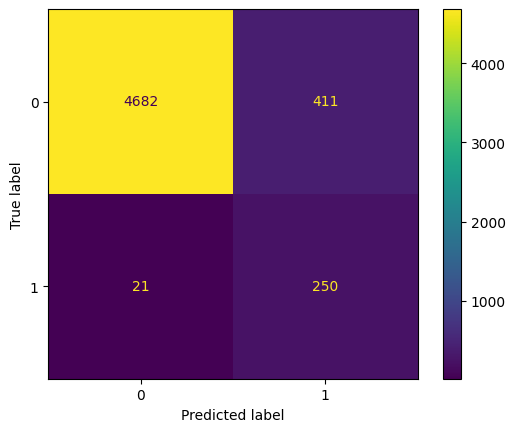

In [36]:
y_pred_nb = pipeline_nb.predict(X_test)
evaluate(y_test, y_pred_nb)

### Random forest

In [37]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [38]:
pipeline_rf.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text'),
                                                 ('employment_type',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['employment_type']),
                                                 ('required_experience',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['required_experienc...
                                                 ('has_company_logo',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_company_logo']),
                                                 ('has_questions',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_questions']),
                                                 ('telecommuting',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['telecommuting'])])),
                ('classifier', RandomForestClassifier())])

Accuracy = 0.9794929157345265
Precision = 0.9938650306748467
Recall = 0.5977859778597786
F1 Score = 0.7465437788018433


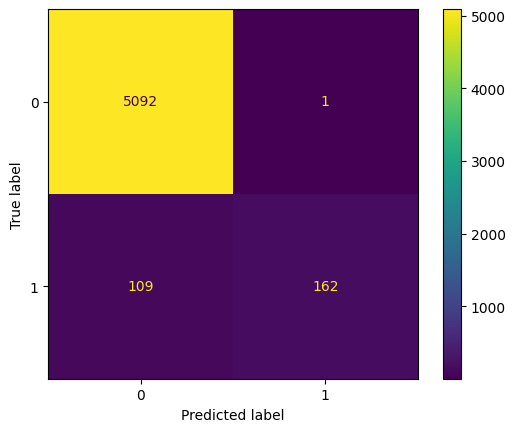

In [39]:
y_pred_rf = pipeline_rf.predict(X_test)
evaluate(y_test, y_pred_rf)

### Logistic regression

In [40]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [41]:
pipeline_lr.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text'),
                                                 ('employment_type',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['employment_type']),
                                                 ('required_experience',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['required_experienc...
                                                 ('has_company_logo',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_company_logo']),
                                                 ('has_questions',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_questions']),
                                                 ('telecommuting',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['telecommuting'])])),
                ('classifier', LogisticRegression())])

Accuracy = 0.9701715137956749
Precision = 0.6504065040650406
Recall = 0.8856088560885609
F1 Score = 0.75


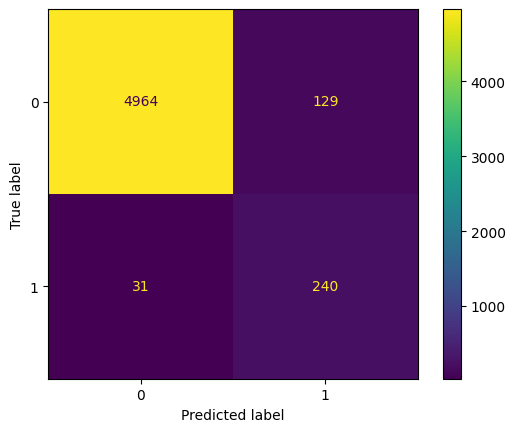

In [42]:
y_pred_lr = pipeline_lr.predict(X_test)
evaluate(y_test, y_pred_lr)

In [43]:
joblib.dump(pipeline_lr, 'models/logistic_regression_model.pkl')

['logistic_regression_model.pkl']

### SVM

In [44]:
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1))
])

In [45]:
pipeline_svm.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text'),
                                                 ('employment_type',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['employment_type']),
                                                 ('required_experience',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['required_experienc...
                                                 ('has_company_logo',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_company_logo']),
                                                 ('has_questions',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['has_questions']),
                                                 ('telecommuting',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['telecommuting'])])),
                ('classifier', SVC(C=1, kernel='linear'))])

Accuracy = 0.9869500372856077
Precision = 0.91701244813278
Recall = 0.8154981549815498
F1 Score = 0.86328125


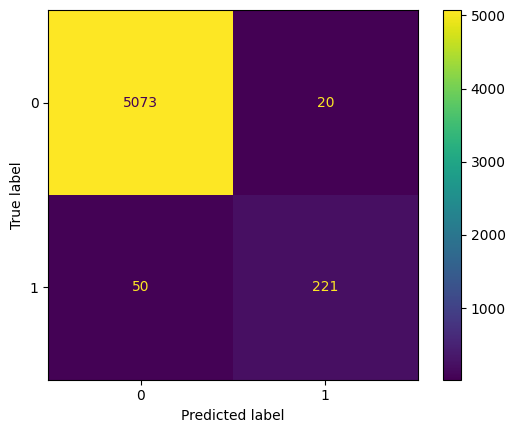

In [46]:
y_pred_svm = pipeline_svm.predict(X_test)
evaluate(y_test, y_pred_svm)

### XGBoost

In [47]:
pipeline_xgb= Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [48]:
pipeline_xgb.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'text'),
                                                 ('employment_type',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['employment_type']),
                                                 ('required_experience',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['required_experienc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Accuracy = 0.9794929157345265
Precision = 0.8060836501901141
Recall = 0.7822878228782287
F1 Score = 0.7940074906367042


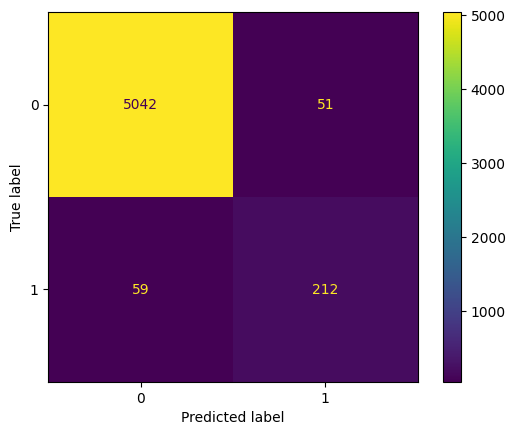

In [49]:
y_pred_xgb = pipeline_xgb.predict(X_test)
evaluate(y_test, y_pred_xgb)

In [50]:
joblib.dump(pipeline_xgb, 'models/xgb_model.pkl')

['xgb_model.pkl']